# Функции активации



Сегодня обсудим:
1. Какие есть функции активации нейронов (Sigmoid, ReLU, ELU, Leaky ReLU...)
2. Плюсы каждой функции активации
3. Минусы каждой функции активации
4. Как написать свою функцию активации

## Для чего нужны?

<img src='https://drive.google.com/uc?id=1gF12si7S9po9bBfJ9Q7bfmM5v55vi3tE'>

Наш нейрон из себя представляет взвешенную сумму:

$$y = \sum{XW} + bias$$

И значение $y$ может изменяться от $-∞$ до $+∞$. И значит *всегда* этот нейрон будет пропускать через себя сигнал. У него **нет границы** активации.

А если вспомним биологический нейрон, то чтобы нейрон активировался (пропустил информацию дальше), нужно поднакопить необходимый сигнал. А значит, раз искусственный нейрон основан на биологическом нейроне, то и **активировать** его мы будем должным образом.

И поможет нам в этом фукнция активации. Ее задача заключается в том, чтобы проверять, является ли нейрон активированным, или его можно проигнорировать.

## Основная задача на сегодня

In [1]:
from keras.datasets import fashion_mnist

(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()

In [2]:
class_names = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

In [4]:
class_names[9]

'Ankle boot'

In [3]:
y_train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [5]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

In [6]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

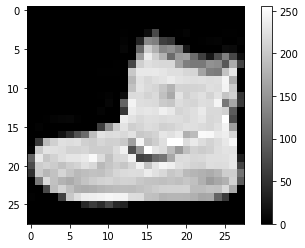

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(X_train[0], cmap='gray')
plt.colorbar()
plt.show()

Нормализуем данные, из диапазона от 0 до 255 переводим в диапазон от 0 до 1.

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Какие бывают функции активации?




### Линейная функция

$$A(x) = x$$

Линейная функция представляет собой прямую линию и она пропорциональна входу.

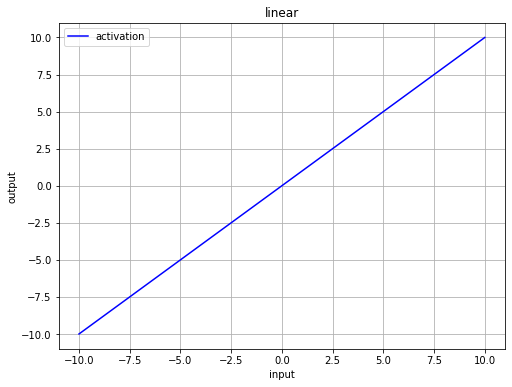

In [9]:
from keras.activations import linear
import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(-10, 10, 100)
y = linear(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.ylabel('output')
plt.xlabel('input')
plt.title('linear')
plt.legend()
plt.grid();


Производная такой функции по $x$ равняется:

$$\frac{∂A}{∂x} = 1$$

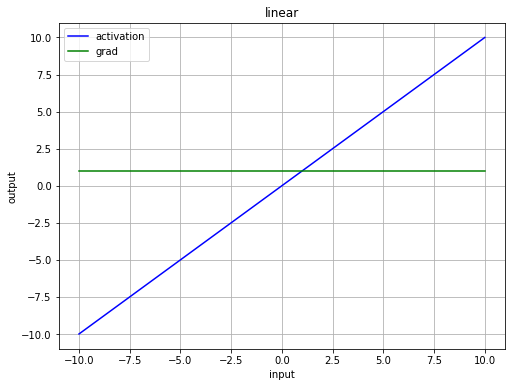

In [ ]:
x = np.linspace(-10, 10, 100)
y = linear(x)

grad_y = np.ones_like(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.plot(x, grad_y, c='g', label='grad')
plt.ylabel('output')
plt.xlabel('input')
plt.title('linear')
plt.legend()
plt.grid();

#### Первая проблема

Для этой функции производная всегда одинакова в любой точке.

А это значит, что градиент никак не связан с входом ($x$). Градиент - постоянный вектор, а спуск идет по **постоянному** градиенту. Если есть ошибочное предсказание, то изменения, сделанные обратным распространением ошибки, тоже постоянны вне зависимости от входа.

Чтобы это проверить, создадим обучающие данные, будем обучать нейронную сеть на воспроизведение входа.

In [ ]:
import numpy as np

X = np.array([[1], [3], [2]])
y = np.array([[1, 3, 2]]).T

Сделаем один линейные слой с линейной активацией и уберем свободный вес.

In [15]:
from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf
tf.random.set_seed(1)


model = Sequential([
    Dense(1, input_shape=(1,), activation='linear', use_bias=False),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 1         
                                                                 
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.get_weights()

[array([[-1.1600207]], dtype=float32)]

Будем следить за градиентами на очень низком уровне, для этого нам потребуется объект из tensorflow `GradientTape`, который записывает градиенты.

In [ ]:
from keras.losses import MSE


for i in range(3):
    with tf.GradientTape() as tape:
        pred = model(X[i])
        print('Prediction is', pred.numpy(), 'True is', y[i])

        loss_value = MSE(y[i], pred)
        print('Loss is', loss_value.numpy())

        grads = tape.gradient(loss_value, model.trainable_weights)
        print('Grad are', grads / loss_value)
        print('_' * 40)

Prediction is [[-1.1600207]] True is [1]
Loss is [4.66569]
Grad are tf.Tensor([[[-0.925917]]], shape=(1, 1, 1), dtype=float32)
________________________________________
Prediction is [[-3.480062]] True is [3]
Loss is [41.991203]
Grad are tf.Tensor([[[-0.925917]]], shape=(1, 1, 1), dtype=float32)
________________________________________
Prediction is [[-2.3200414]] True is [2]
Loss is [18.66276]
Grad are tf.Tensor([[[-0.925917]]], shape=(1, 1, 1), dtype=float32)
________________________________________


#### Вторая проблема


<img src='https://drive.google.com/uc?id=1pLd9DW7HxfcxoXyS3mRaENS8ugpxeSou' width=800>


Раз каждый слой активируется линейной функцией, то в следующий слой пойдет линейная связь от входа. В другом слое получаем линейную комбинацию, прогоняем через линейную активацию и дальше.

Нет разницы, сколько у нас слоев. Ведь финальная функция активации в последнем слое будет просто линейной функцией от входных параметров на первом слое.

Значит, любое количество слоев можно заменить одним. Больше нет смысла ставить подряд слои с линейной активацией.



### Сигмоида

Сигмоида - одна из самых частых активационных функций в нейросетях.


$$A(x) = \frac{1}{1 + e^{-x}}$$


**Преимущества:**
1. Сигмоида — **нелинейная функция**, а комбинация таких функций производит тоже нелинейную функцию. А значит проблема линейной функция здесь неактуальна, мы можем обучать подряд **много слоев** и это будет иметь смысл.
2. В диапазоне значений сигнала от -2.5 до 2.5 значения активации меняются очень быстро. А значит, что любое изменение значения сигнала в этой области повлечет существенное изменение значения активации.
3. Сигмоида идеально подходит для задач **бинарной классификации**. Она стремится привести значения к одной из сторон кривой, по итогу получаем четкие границы предсказания
4. У сигмоиды фиксированный диапазон значений функции — [0,1], а линейная функция обладает диапазоном ($-∞$, $+∞$). А значит в случае с сигмоидой **не будет ошибок** с большими значениями активаций




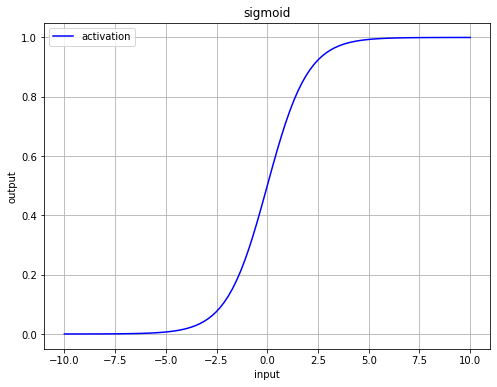

In [ ]:
from keras.activations import sigmoid


x = np.linspace(-10, 10, 100)
y = sigmoid(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.ylabel('output')
plt.xlabel('input')
plt.title('sigmoid')
plt.legend()
plt.grid();

Производная сигмоиды

$$\sigma(z) = \frac{1}{1 + exp(-z)}$$

$$\frac{d\sigma(z)}{dz} = -\frac{1}{(1 + exp(-z))^2}(-exp(-z)) = \frac{exp(-z)}{(1 + exp(-z))^2} \text{(*)} = \frac{1}{1 + exp(-z)}(1-\frac{1}{1 + exp(-z)}) = \sigma(1-\sigma)$$

$ (*)\frac{exp(-z) +1-1}{(1 + exp(-z))^2} = \frac{1 + exp(-z) -1}{(1 + exp(-z))^2}= \frac{1 + exp(-z)}{(1 + exp(-z))^2} - \frac{1}{(1 + exp(-z))^2}=$

$ = \frac{1}{(1 + exp(-z))} - \frac{1}{(1 + exp(-z))}\frac{1}{(1 + exp(-z))} = \frac{1}{(1 + exp(-z))}(1- \frac{1}{(1 + exp(-z))}) $

In [10]:
def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

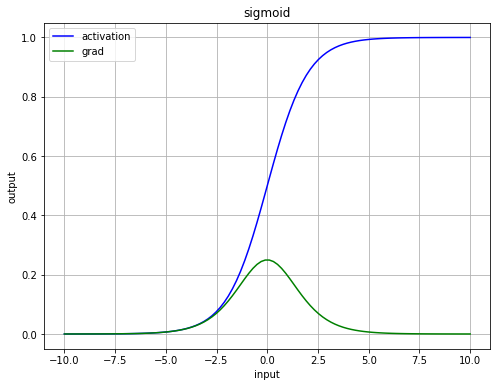

In [12]:
from keras.activations import sigmoid

x = np.linspace(-10, 10, 100)
y = sigmoid(x)

grad_y = sigmoid_grad(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.plot(x, grad_y, c='g', label='grad')
plt.ylabel('output')
plt.xlabel('input')
plt.title('sigmoid')
plt.legend()
plt.grid();

In [ ]:
0.25 ** 5 * 0.001

9.765625e-07

#### Проблема

При приближении к концам сигмоиды значения активации очень слабо изменяются. Это означает, что градиент в таких областях имеет очень мальнькие значения. А из-за этого рождается проблема **затухающих градиентов**

Градиент получается настолько маленьким или же вообще нулевым, что обучение замораживается или же идет очень медленно.

In [16]:
from keras.layers import Flatten
import tensorflow as tf
tf.random.set_seed(9)

model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(32, activation='sigmoid'),
    Dense(16, activation='sigmoid'),
    Dense(10, activation='sigmoid')
])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               100480    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 10)                170       
                                                                 
Total params: 111,514
Trainable params: 111,514
Non-tr

In [17]:
from keras.losses import CategoricalCrossentropy
from keras.optimizer_v2 import gradient_descent

optimizer = gradient_descent.SGD(learning_rate=0.01)
loss_fn = CategoricalCrossentropy()

ModuleNotFoundError: No module named 'keras.optimizer_v2'

In [ ]:
# Подготовим тренировочный датасет
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0]).batch(batch_size)

In [ ]:
for X, y in train_dataset:
    print(X.shape)
    break

(64, 28, 28)


In [ ]:
grad_log = []

epochs = 2

for epoch in range(epochs):
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            preds = model(x_batch_train)

            loss_value = loss_fn(y_batch_train, preds)

            grads = tape.gradient(loss_value, model.trainable_weights)
            g_g = []

            for g_s in grads:
                if len(g_s.numpy().shape) == 2:
                    g_g.append(g_s.numpy()[0, 0])

        grad_log.append(g_g)

        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 200 == 0:
            print(f'Epoch {epoch + 1}/{epochs}', end='. ')
            print(f'Step {step}. Train loss: {loss_value}')

Epoch 1/2. Step 0. Train loss: 2.47444748878479
Epoch 1/2. Step 200. Train loss: 2.2992992401123047
Epoch 1/2. Step 400. Train loss: 2.307833433151245
Epoch 1/2. Step 600. Train loss: 2.310232162475586
Epoch 1/2. Step 800. Train loss: 2.302314281463623
Epoch 2/2. Step 0. Train loss: 2.2998695373535156
Epoch 2/2. Step 200. Train loss: 2.301020622253418
Epoch 2/2. Step 400. Train loss: 2.3048338890075684
Epoch 2/2. Step 600. Train loss: 2.3041810989379883
Epoch 2/2. Step 800. Train loss: 2.2992186546325684


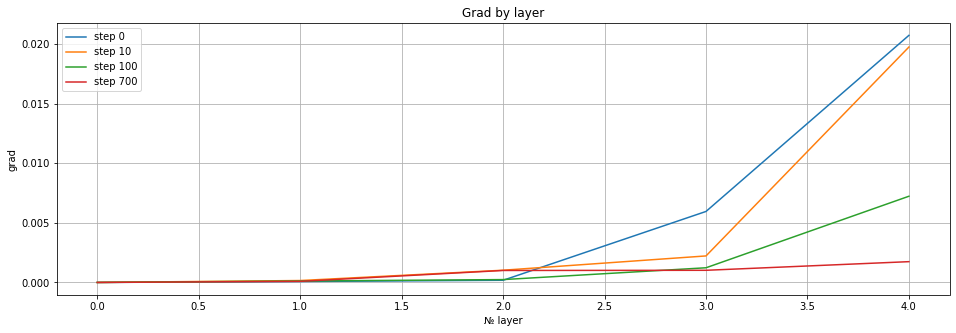

In [ ]:
grad_log = np.array(grad_log)

plt.figure(figsize=(16, 5))
plt.title('Grad by layer')
plt.xlabel('№ layer')
plt.ylabel('grad')
plt.grid()
plt.plot(np.abs(grad_log[0, :]), label='step 0')
plt.plot(np.abs(grad_log[10, :]), label='step 10')
plt.plot(np.abs(grad_log[100, :]), label='step 100')
plt.plot(np.abs(grad_log[700, :]), label='step 700')
plt.legend()
plt.show()

### Тангенс

$$tanh(x)={\frac {e^{x}-e^{-x}}{e^{x}+e^{-x}}}={\frac {e^{2x}-1}{e^{2x}+1}} = 2σ(2x) - 1$$

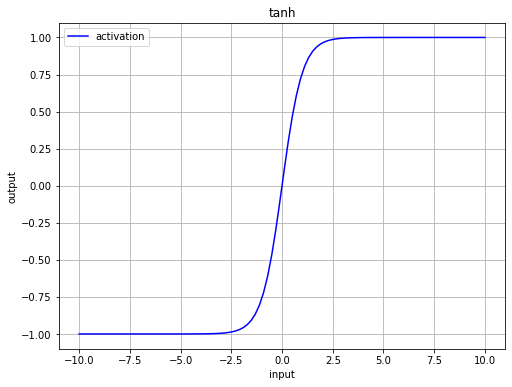

In [ ]:
from keras.activations import tanh


x = np.linspace(-10, 10, 100)
y = tanh(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.ylabel('output')
plt.xlabel('input')
plt.title('tanh')
plt.legend()
plt.grid();

Производная тангенса

$$∂\tanh(z) = \frac{1}{ch^2(x)} = \frac{1}{(\frac{e^x + e^{-x}}{2})^2}$$

$$ch(x) = \frac{e^x + e^{-x}}{2}$$

In [ ]:
def tanh_grad(x):
    return 1 / (np.exp(x) + np.exp(-x) / 2) ** 2

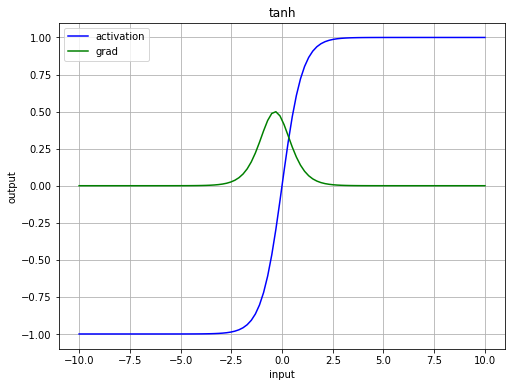

In [ ]:
x = np.linspace(-10, 10, 100)
y = tanh(x)

grad_y = tanh_grad(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.plot(x, grad_y, c='g', label='grad')
plt.ylabel('output')
plt.xlabel('input')
plt.title('tanh')
plt.legend()
plt.grid();

Гиперболический тангенс очень похож на сигмоиду, только вот производная у него чуть больше, но все остальные плюсы и минусы остаются.

**Плюсы:**
1. Тангенс - **нелинейная функция**, можем обучать подряд много слоев и это будет иметь смысл.
2. В диапазоне значений сигнала от -2.5 до 2.5 значения активации меняются очень быстро. А значит, что любое изменение значения сигнала в этой области повлечет существенное изменение значения активации.
3. Тангенс идеально подходит для задач **бинарной классификации**. Он стремится привести значения к одной из сторон кривой.
4. У тангенса фиксированный диапазон значений функции — [-1,1]. А значит не будет ошибок с большими значениями аткиваций


**Минусы:**
1. При приближении к концам тангенса значения активации очень слабо изменяются. Имеем проблему **затухающих градиентов**.

### ReLU


$$A(x) = max(0, x)$$

Может показаться, что у ReLU все те же самые проблемы, что и у линейной функция. Но на самом деле, ReLU нелинейна. А это значит, что мы можем создавать подряд много слоев.

ReLU менее требовательна к вычислительным ресурсам, чем тангенс или сигмоида, поэтому ReLU пользуется популярностью при создании глубоких нейронных сетей.

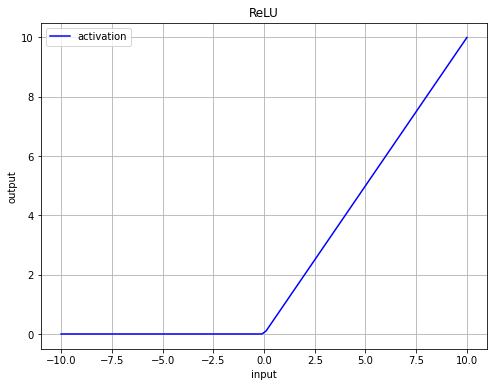

In [ ]:
from keras.activations import relu


x = np.linspace(-10, 10, 100)
y = relu(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.ylabel('output')
plt.xlabel('input')
plt.title('ReLU')
plt.legend()
plt.grid();

Производная ReLU

In [ ]:
def relu_grad(x):
    return np.where(x >= 0, 1, 0)

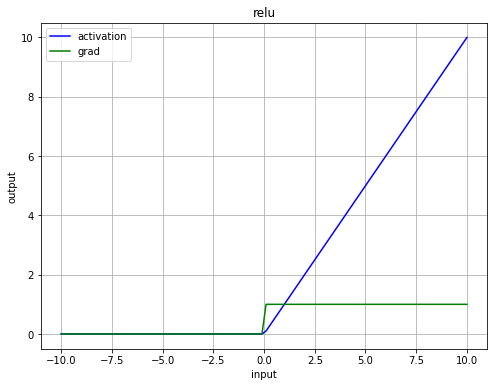

In [ ]:
x = np.linspace(-10, 10, 100)
y = relu(x)

grad_y = relu_grad(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.plot(x, grad_y, c='g', label='grad')
plt.ylabel('output')
plt.xlabel('input')
plt.title('relu')
plt.legend()
plt.grid();

Проверим, что проблемы затухающих градиентов больше нет.

In [ ]:
tf.random.set_seed(9)

model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(10, activation='sigmoid')
])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 10)                170       
                                                                 
Total params: 111,514
Trainable params: 111,514
Non-tr

In [ ]:
optimizer = gradient_descent.SGD(learning_rate=0.01)
loss_fn = CategoricalCrossentropy()

In [ ]:
grad_log = []

epochs = 2

for epoch in range(epochs):
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            preds = model(x_batch_train)

            loss_value = loss_fn(y_batch_train, preds)

            grads = tape.gradient(loss_value, model.trainable_weights)
            g_g = []

            for g_s in grads:
                if len(g_s.numpy().shape) == 2:
                    g_g.append(g_s.numpy()[0, 0])

        grad_log.append(g_g)

        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 200 == 0:
            print(f'Epoch {epoch + 1}/{epochs}', end='. ')
            print(f'Step {step}. Train loss: {loss_value}')

Epoch 1/2. Step 0. Train loss: 2.351628541946411
Epoch 1/2. Step 200. Train loss: 1.8318686485290527
Epoch 1/2. Step 400. Train loss: 1.2116221189498901
Epoch 1/2. Step 600. Train loss: 0.8003709316253662
Epoch 1/2. Step 800. Train loss: 0.4912152886390686
Epoch 2/2. Step 0. Train loss: 0.7042253017425537
Epoch 2/2. Step 200. Train loss: 0.6148197650909424
Epoch 2/2. Step 400. Train loss: 0.5967527031898499
Epoch 2/2. Step 600. Train loss: 0.5230977535247803
Epoch 2/2. Step 800. Train loss: 0.48200517892837524


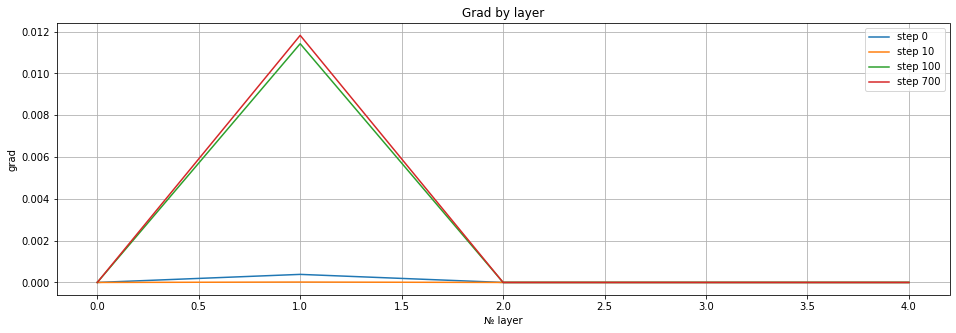

In [ ]:
grad_log = np.array(grad_log)

plt.figure(figsize=(16, 5))
plt.title('Grad by layer')
plt.xlabel('№ layer')
plt.ylabel('grad')
plt.grid()
plt.plot(np.abs(grad_log[0, :]), label='step 0')
plt.plot(np.abs(grad_log[10, :]), label='step 10')
plt.plot(np.abs(grad_log[100, :]), label='step 100')
plt.plot(np.abs(grad_log[700, :]), label='step 700')
plt.legend()
plt.show()

#### Проблема


Если имеем большую нейронную сеть с огромным количеством нейронов, то использование сигмоиды или гиперболического тангенса повлекут за собой **активацию буквально всех нейронов**. А в идеале хочется, чтобы некоторые нейроны не были активированы, чтобы сеть была легче.

ReLu может это сделать. К примеру, если у нас есть нейросеть со случайно инициализированными весами, то 50% активаций равны 0 по ReLU.

Но и тут есть проблема. Градиент на этой части равен 0. А значит, веса сети не будут изменяться во время обучения.


Но существуют модификации ReLU, которые помогают эту проблему решить.



In [ ]:
X = np.array([[1], [3], [2]])
y = np.array([[1, 3, 2]]).T

Сделаем один линейные слой с активацией ReLU и уберем свободный вес.

In [ ]:
tf.random.set_seed(1)


model = Sequential([
    Dense(1, input_shape=(1,), activation='relu', use_bias=False),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1)                 1         
                                                                 
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.get_weights()

[array([[-1.1600207]], dtype=float32)]

Будем следить за градиентами на очень низком уровне.

In [ ]:
for i in range(3):
    with tf.GradientTape() as tape:
        pred = model(X[i])
        print('Prediction is', pred.numpy(), 'True is', y[i])

        loss_value = MSE(y[i], pred)
        print('Loss is', loss_value.numpy())

        grads = tape.gradient(loss_value, model.trainable_weights)
        print('Grad are', grads / loss_value)
        print('_' * 40)

Prediction is [[0.]] True is [1]
Loss is [1.]
Grad are tf.Tensor([[[-0.]]], shape=(1, 1, 1), dtype=float32)
________________________________________
Prediction is [[0.]] True is [3]
Loss is [9.]
Grad are tf.Tensor([[[-0.]]], shape=(1, 1, 1), dtype=float32)
________________________________________
Prediction is [[0.]] True is [2]
Loss is [4.]
Grad are tf.Tensor([[[-0.]]], shape=(1, 1, 1), dtype=float32)
________________________________________


### Leaky ReLU


$$A(x) = max(0.1x, x)$$


Например, для решения проблемы нулевого градиента имеет смысл заменить горизонтальную часть функции на линейную.

Получаем слегка отклоненную линию от горизонтального положения. Суть в том, чтобы сделать градиент неравным нулю и постепенно восстанавливать его во время тренировки.

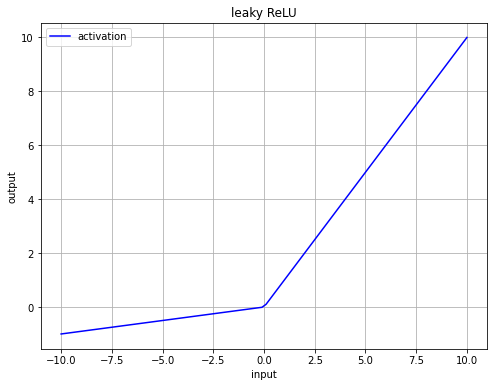

In [ ]:
from keras.activations import leaky_relu


x = np.linspace(-10, 10, 100)
y = leaky_relu(x, alpha=0.1)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.ylabel('output')
plt.xlabel('input')
plt.title('leaky ReLU')
plt.legend()
plt.grid();

Производная leaky ReLU

In [ ]:
def leaky_relu_grad(x):
    return np.where(x >= 0, 1, 0.1)

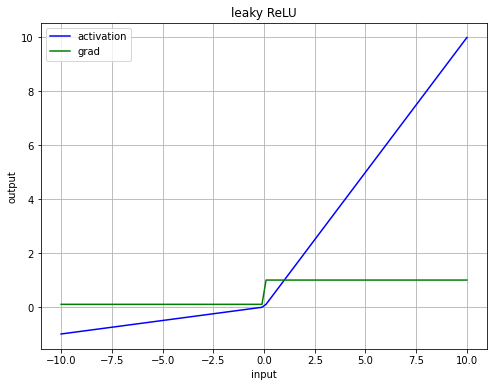

In [ ]:
x = np.linspace(-10, 10, 100)
y = leaky_relu(x, alpha=0.1)

grad_y = leaky_relu_grad(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.plot(x, grad_y, c='g', label='grad')
plt.ylabel('output')
plt.xlabel('input')
plt.title('leaky ReLU')
plt.legend()
plt.grid();

### ELU


<img src='https://drive.google.com/uc?id=1bCygDVQiwQP7lu-m0gyQy6EjyCSa1YA9' width=200>

Или же можем нелинейно отклонять линию от горизонтального положения, а более плавно.

Но суть остается такая же - делаем градиент ненулевым.

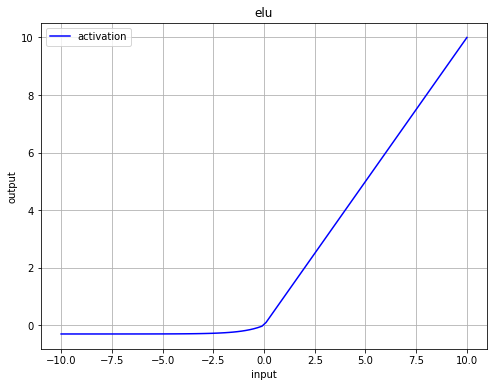

In [ ]:
from keras.activations import elu


x = np.linspace(-10, 10, 100)
alpha = 0.3
y = elu(x, alpha=alpha)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.ylabel('output')
plt.xlabel('input')
plt.title('elu')
plt.legend()
plt.grid();

Производная ELU

In [ ]:
def elu_grad(x):
    return np.where(x >= 0, 1, elu(x, alpha=alpha) + alpha)

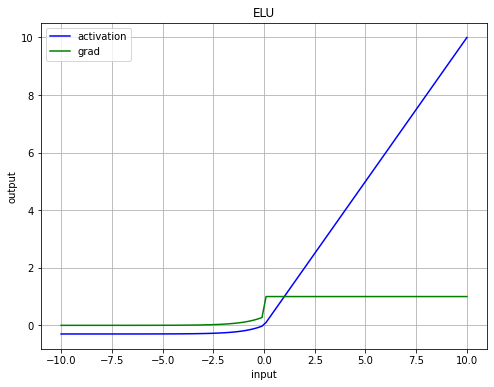

In [ ]:
x = np.linspace(-10, 10, 100)
y = elu(x, alpha=alpha)

grad_y = elu_grad(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, c='b', label='activation')
plt.plot(x, grad_y, c='g', label='grad')
plt.ylabel('output')
plt.xlabel('input')
plt.title('ELU')
plt.legend()
plt.grid();

### Как выбрать функцию активации?

Как и во всем глубоком обучении, здесь нет очевидного ответа. Выбирайте ту функцию, которая ведет к более быстрому обучению.

Есть только однозначный ответ касаемо функции активации на последнем слое. Если у вас задача классификации, то самый лучший кандидат - sigmoid, т.к. выдает по сути вероятность быть одним классом или другим.

А если задача регрессии, то выбирайте ReLU - если у вас не может быть отрицательного целевого значения или же линейную активацию.

Ну и конечно же, можно использоваться кастомные функции активации.

### Кастомная функция активации

Посмотрим на проблемы очень больших градиентов.

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(10, activation='sigmoid')
])


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 10)                170       
                                                                 
Total params: 111,514
Trainable params: 111,514
Non-tr

Для этого поставим очень большие веса.

Такие веса могут получится, если градиент будет всегда большой.

In [ ]:
np.random.seed(9)

new_weights = []

for weights in model.get_weights():
    if len(weights.shape) == 2:
        new_weights.append(np.random.randn(weights.shape[0], weights.shape[1]) * 100)
    else:
        new_weights.append(np.random.randn(weights.shape[0]) * 100)

model.set_weights(new_weights)

model.get_weights()[:2]

[array([[ 1.10855468e-01, -2.89544067e+01, -1.11606628e+02, ...,
          2.70807247e+01, -1.09553963e+02,  2.40134293e+02],
        [-2.79909744e+01,  2.03080078e+02, -8.19394684e+00, ...,
         -3.82227927e-01,  1.05748680e+02, -9.83664932e+01],
        [ 1.08536072e+02,  3.65864944e+01, -1.09298759e+02, ...,
         -5.81144371e+01,  4.14889984e+01,  1.60726120e+02],
        ...,
        [ 1.35224182e+02,  2.94914799e+01,  1.18652184e+02, ...,
          4.81741476e+00, -2.53905319e+02, -4.74941177e+01],
        [-3.37093697e+01,  1.03940331e+02,  1.14126289e+02, ...,
          1.74861115e+02,  4.74479866e+00,  1.33079357e+01],
        [ 2.64444885e+01, -1.50783691e+02,  1.20068794e+02, ...,
          7.30409470e+01,  9.83183594e+01,  1.32491974e+02]], dtype=float32),
 array([ -81.39623  ,   17.539917 ,  -72.668785 ,    2.2356956,
          33.181274 ,  119.915825 ,   89.62817  ,  -21.945011 ,
        -127.10773  ,   84.82333  , -114.00925  , -107.28623  ,
        -105.227394 , 

In [ ]:
optimizer = gradient_descent.SGD(learning_rate=0.01)
loss_fn = CategoricalCrossentropy()

А видим, что уже ошибка посчитаться не может, что-то пошло не так.

In [ ]:
grad_log = []

epochs = 2

for epoch in range(epochs):
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            preds = model(x_batch_train)

            loss_value = loss_fn(y_batch_train, preds)

            grads = tape.gradient(loss_value, model.trainable_weights)
            g_g = []

            for g_s in grads:
                if len(g_s.numpy().shape) == 2:
                    g_g.append(g_s.numpy()[0, 0])

        grad_log.append(g_g)

        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 200 == 0:
            print(f'Epoch {epoch + 1}/{epochs}', end='. ')
            print(f'Step {step}. Train loss: {loss_value}')

Epoch 1/2. Step 0. Train loss: 58217132457984.0
Epoch 1/2. Step 200. Train loss: nan
Epoch 1/2. Step 400. Train loss: nan
Epoch 1/2. Step 600. Train loss: nan
Epoch 1/2. Step 800. Train loss: nan
Epoch 2/2. Step 0. Train loss: nan
Epoch 2/2. Step 200. Train loss: nan
Epoch 2/2. Step 400. Train loss: nan
Epoch 2/2. Step 600. Train loss: nan
Epoch 2/2. Step 800. Train loss: nan


А веса тоже посчитаться не могут, они вышли за разрешенные значения float32.

In [ ]:
model.get_weights()[:2]

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, 

Но можем изменить фукнцию активации ReLU.

Раньше у неё не было ограничений в большую сторону, а значит выходные значения активации могли быть очень большими.

Но теперь поставим ограничения в 6, чтобы как-то утихомирить наши сигнала, а значит и веса.

In [ ]:
from keras import backend as K

def my_relu(x):
    return K.relu(x, max_value=6)

In [ ]:
my_relu([10, 0, -2, 7])

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([6, 0, 0, 6], dtype=int32)>

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation=my_relu),
    Dense(64, activation=my_relu),
    Dense(32, activation=my_relu),
    Dense(16, activation=my_relu),
    Dense(10, activation='sigmoid')
])


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               100480    
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 10)                170       
                                                                 
Total params: 111,514
Trainable params: 111,514
Non-tr

In [ ]:
model.set_weights(new_weights)

In [ ]:
optimizer = gradient_descent.SGD(learning_rate=0.01)
loss_fn = CategoricalCrossentropy()

Обучение идёт, nan'ов не видно.

In [ ]:
grad_log = []

epochs = 2

for epoch in range(epochs):
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            preds = model(x_batch_train)

            loss_value = loss_fn(y_batch_train, preds)

            grads = tape.gradient(loss_value, model.trainable_weights)
            g_g = []

            for g_s in grads:
                if len(g_s.numpy().shape) == 2:
                    g_g.append(g_s.numpy()[0, 0])

        grad_log.append(g_g)

        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 200 == 0:
            print(f'Epoch {epoch + 1}/{epochs}', end='. ')
            print(f'Step {step}. Train loss: {loss_value}')

Epoch 1/2. Step 0. Train loss: 1820.707763671875
Epoch 1/2. Step 200. Train loss: 1920.79052734375
Epoch 1/2. Step 400. Train loss: 1579.050048828125
Epoch 1/2. Step 600. Train loss: 1625.4769287109375
Epoch 1/2. Step 800. Train loss: 1563.5634765625
Epoch 2/2. Step 0. Train loss: 1265.1722412109375
Epoch 2/2. Step 200. Train loss: 1093.002685546875
Epoch 2/2. Step 400. Train loss: 1185.621337890625
Epoch 2/2. Step 600. Train loss: 1491.9697265625
Epoch 2/2. Step 800. Train loss: 1223.733154296875


In [ ]:
model.get_weights()[:2]

[array([[ 1.10855468e-01, -2.89544067e+01, -1.11606628e+02, ...,
          2.70807247e+01, -1.09553963e+02,  2.40134293e+02],
        [-2.79909744e+01,  2.03080078e+02, -8.19394684e+00, ...,
         -3.82227927e-01,  1.05748680e+02, -9.83664932e+01],
        [ 1.08536072e+02,  3.65864944e+01, -1.09298759e+02, ...,
         -5.81144371e+01,  4.14889984e+01,  1.60726120e+02],
        ...,
        [ 1.35224182e+02,  2.94914799e+01,  1.18652184e+02, ...,
          4.81741476e+00, -2.53905319e+02, -4.74941177e+01],
        [-3.37093697e+01,  1.03940331e+02,  1.14126289e+02, ...,
          1.74861115e+02,  4.74479866e+00,  1.33079357e+01],
        [ 2.64444885e+01, -1.50783691e+02,  1.20068794e+02, ...,
          7.30409470e+01,  9.83183594e+01,  1.32491974e+02]], dtype=float32),
 array([ -81.39623  ,   17.539917 ,  -72.668785 ,    2.2356956,
          33.181274 ,  119.915825 ,   89.62817  ,  -21.945011 ,
        -127.10773  ,   84.82333  , -114.00925  , -107.28623  ,
        -105.227394 , 

## Summary

Сегодня обсудили:
1. Какие есть функции активации нейронов (Sigmoid, ReLU, ELU, Leaky ReLU...)
2. Плюсы каждой функции активации
3. Минусы каждой функции активации
4. Как написать свою функцию активации



<table>
<tr>
<th>
Функция активации
</th>

<th>
Плюсы
</th>

<th>
Минусы
</th>
</tr>

<tr>
<td>
linear
</td>

<td>

        1. Меньше времени на вычисления
</td>

<td>

        1. Линейная функция
        2. Нефиксированный диапазон значений функции — [-∞,+∞]
        3. Константный градиент
</td>
</tr>


<tr>
<td>
Sigmoid
</td>

<td>

        1. Нелинейная функция
        2. В диапазоне значений сигнала от -2.5 до 2.5 значения активации меняются очень быстро
        3. Фиксированный диапазон значений функции — [0,1]

</td>

<td>

        1. Затухают градиенты

</td>
</tr>

<tr>
<td>
Tanh
</td>

<td>

        1. Нелинейная функция
        2. В диапазоне значений сигнала от -2.5 до 2.5 значения активации меняются очень быстро
        3. Фиксированный диапазон значений функции — [-1,1]
</td>

<td>

        1. Затухают градиенты

</td>
</tr>

<tr>
<td>
ReLU
</td>

<td>

        1. Меньше времени на вычисления
        2. Меньше вес у сети
        3. Нет проблемы затухающих градиентов
    
</td>

<td>

        1. Нулевые градиенты у сигналов, которые меньше 0
        2. Нефиксированный диапазон значений функции
</td>
</tr>

<tr>
<td>
Leaky ReLU
</td>

<td>

        1. Нет проблемы нулевых градиентов

</td>

<td>

        1. Нужно подбирать значение alpha
        2. Нефиксированный диапазон значений функции
</td>
</tr>

<tr>
<td>
ELU
</td>

<td>

        1. Нет проблемы нулевых градиентов
        2. Имеются негативные выходы, что помогает нейронке направлять веса в нужное напрвление
</td>

<td>

        1. Больше времени на вычисления
        2. Нефиксированный диапазон значений функции
        3. Нужно подбирать значение alpha
</td>
</tr>

</table>
